## Vision Project Walkthrough

In [1]:
%matplotlib inline
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
#imageio.plugins.ffmpeg.download()

## Generating random images from the test data set and applying threshold

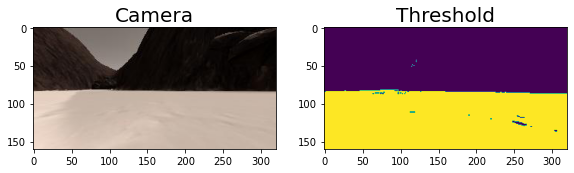

In [10]:
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
index = np.random.randint(0, len(img_list) - 1)
image = mpimg.imread(img_list[index])

fig = plt.figure(figsize=(20,20))
plt.subplot(141)
plt.title('Camera', fontsize = 20 )
plt.imshow(image)
plt.subplot(142)
plt.title("Threshold", fontsize = 20)
plt.imshow(color_thresh(image))

## getting rocks and grid

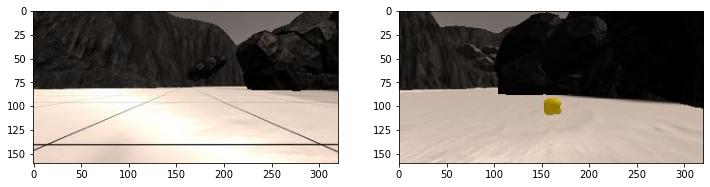

In [4]:
example_grid= "../calibration_images/example_grid1.jpg"
example_rock = "../calibration_images/example_rock1.jpg"
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Warping Image on bird eye view

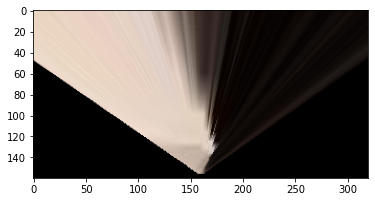

In [5]:
def perspect_transform(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    
    return warped

dst = 3
bottom_offset = 5
source = np.float32([[14, 140],
                     [300, 140],
                     [200, 95],
                     [120, 95]])

destination = np.float32([[image.shape[1] / 2 - dst, image.shape[0] - bottom_offset],
                          [image.shape[1] / 2 + dst, image.shape[0] - bottom_offset],
                          [image.shape[1] / 2 + dst, image.shape[0] - 2*dst - bottom_offset],
                          [image.shape[1] / 2 - dst, image.shape[0] - 2*dst - bottom_offset]])


warped = perspect_transform(image, source, destination)
plt.imshow(warped)
#scipy.misc.imsave('../output/warped_example.jpg', warped)

## Color Thresholding for camera

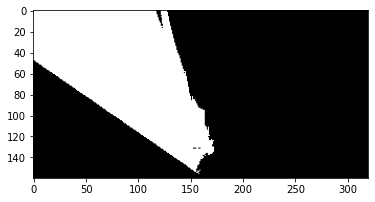

In [6]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:, 0] > rgb_thresh[0]) \
                  &(img[:,:, 1] > rgb_thresh[1]) \
                  &(img[:,:, 2] > rgb_thresh[2])
    
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

threshed = color_thresh(warped)
plt.imshow(threshed, cmap='gray')

## Color thresholding for obstacles

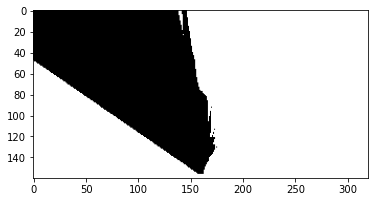

In [7]:
def color_thresh_obstacles(img, rgb_thresh=(115, 115, 115)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] < rgb_thresh[0]) \
                & (img[:,:,1] < rgb_thresh[1]) \
                & (img[:,:,2] < rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 150
    # Return the binary image
    return color_select

obstacles = color_thresh_obstacles(warped)
plt.imshow(obstacles,cmap="gray")

## Color thresholding for rock

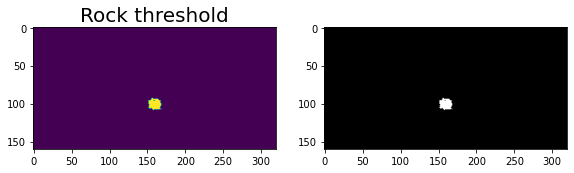

In [8]:
def color_thresh_rock(img, rgb_thresh=(100, 100, 20)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] < rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 150
    # Return the binary image
    return color_select

# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel

rock_thresh = color_thresh_rock(rock_img)
fig = plt.figure(figsize=(20,20))
plt.subplot(141)
plt.title('Rock threshold', fontsize = 20 )
plt.imshow(rock_thresh)
plt.subplot(142)
plt.imshow(rock_thresh, cmap = "gray")

# Adjust to world Coordinates

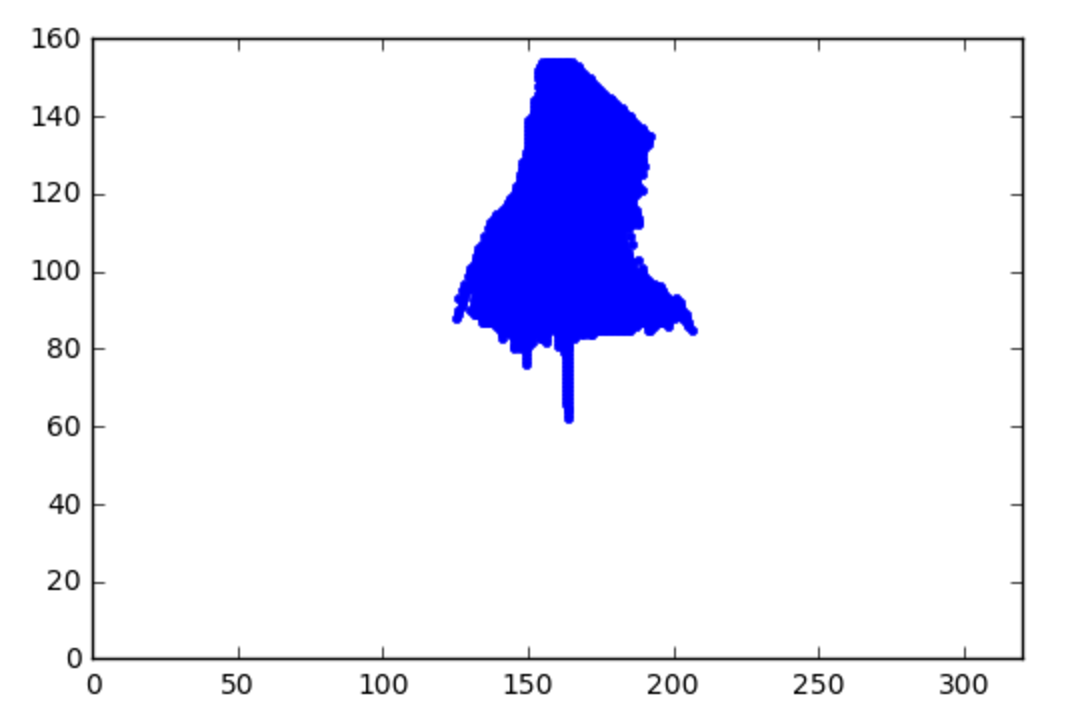

## World Map

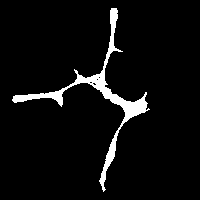

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

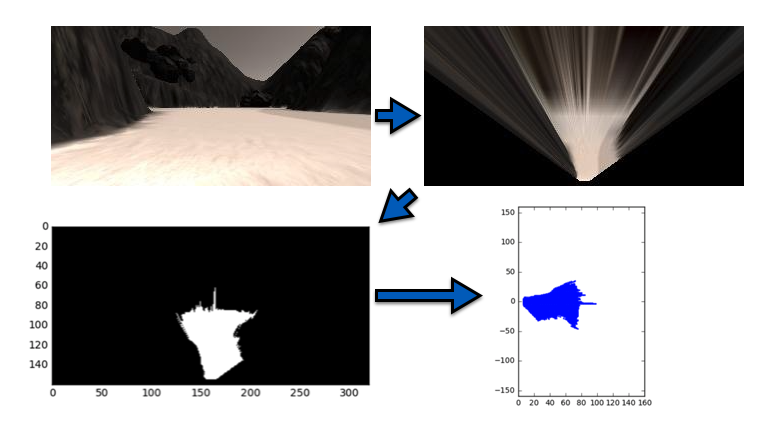

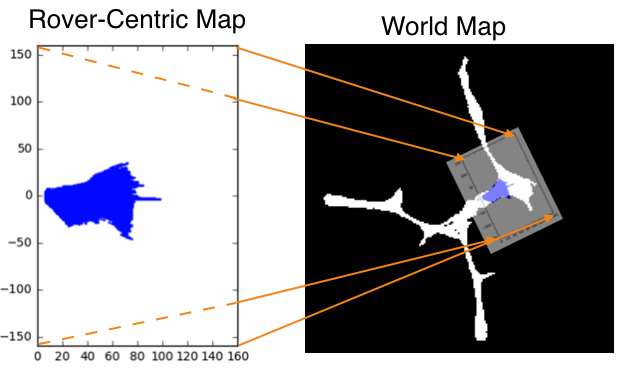

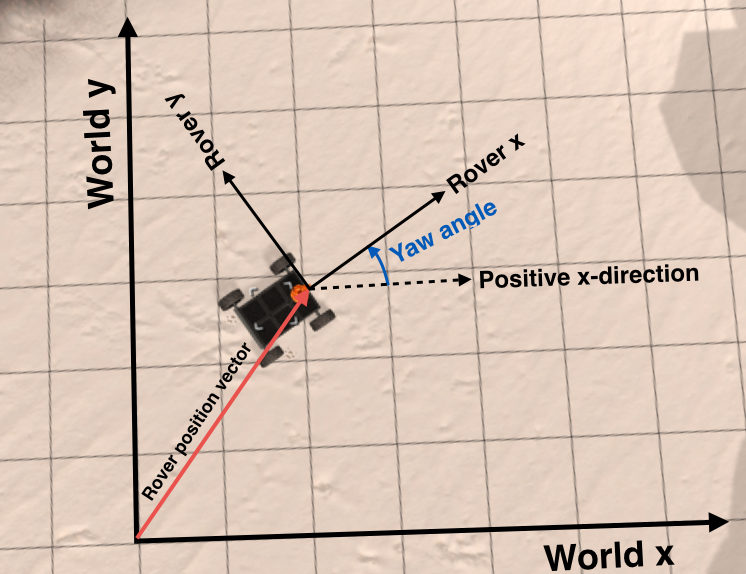

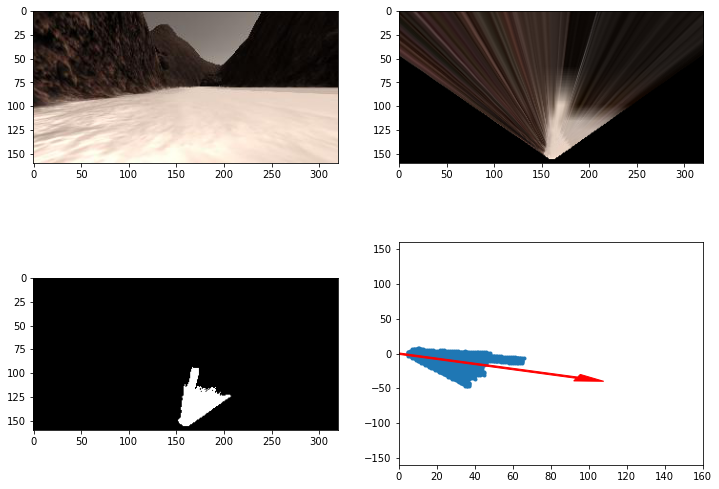

In [9]:
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float32)
    y_pixel = -(xpos - binary_img.shape[0]).astype(np.float32)
    
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to apply a rotation to pixel positions
def rotate_pix(xpix, ypix, yaw):
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad) - (ypix * np.sin(yaw_rad)))
    ypix_rotated = (xpix * np.sin(yaw_rad) + (ypix * np.cos(yaw_rad)))
    return xpix_rotated, ypix_rotated

# Define a function to perform a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot) + xpos
    ypix_translated = (ypix_rot) + ypos
    # Return the result 
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    #Apply rotation
    xpix_rot , ypix_rot = rotate_pix(xpix,ypix, yaw)
    #apply translation
    xpix_trans, ypix_trans = translate_pix(xpix_rot,ypix_rot,xpos,ypos,scale)
    #do rotation, translation, clipping at the same time
    x_pix_world = np.clip(np.int_(xpix_trans), 0, world_size-1)
    y_pix_world = np.clip(np.int_(ypix_trans), 0, world_size-1)
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)

